In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Load the dataset
file_path = 'data/monatszahlen2405_verkehrsunfaelle_export_31_05_24_r.csv'
data = pd.read_csv(file_path)

In [15]:
# Filter for the relevant category and type
filtered_data = data[
    (data['MONATSZAHL'] == 'Alkoholunfälle') &
    (data['AUSPRAEGUNG'] == 'insgesamt') &
    (data['JAHR'] <= 2020)
]
filtered_data = filtered_data[['JAHR', 'MONAT', 'WERT']].dropna()

# Remove summary rows and convert month to datetime
filtered_data = filtered_data[filtered_data['MONAT'] != 'Summe']
filtered_data['MONTH'] = pd.to_datetime(filtered_data['JAHR'].astype(str) + filtered_data['MONAT'].str[-2:], format='%Y%m')
filtered_data = filtered_data[['MONTH', 'WERT']].set_index('MONTH').sort_index()

# Feature engineering: Adding cyclical features
filtered_data['Month_Sin'] = np.sin(2 * np.pi * filtered_data.index.month / 12)
filtered_data['Month_Cos'] = np.cos(2 * np.pi * filtered_data.index.month / 12)

# Store ARIMA and regression results statically
results = pd.DataFrame({
    "Model": [
        "ARIMA (Raw)",
        "ARIMA (Log)",
        "Auto-ARIMA (Raw)",
        "Auto-ARIMA (Log)",
        "Auto-ARIMA (Seasonal Log)",
        "Prophet",
        "Random Forest",
        "Gradient Boosting",
        "Linear Regression",
        "Quadratic Regression"
    ],
    "Forecast": [
        25.622543,
        20.472689,
        22.959208,
        19.571858,
        20.953103,
        22.273038,
        30.900000,
        30.855754,
        9.449203,
        36.770259
    ],
    "Ground Truth": [16.0] * 10,
    "Absolute Error": [
        9.622543,
        4.472689,
        6.959208,
        3.571858,
        4.953103,
        6.273038,
        14.900000,
        14.855754,
        6.550797,
        20.770259
    ],
    "Percentage Error": [
        60.140892,
        27.954303,
        43.495051,
        22.324113,
        30.956891,
        39.206488,
        93.125000,
        92.848461,
        40.942478,
        129.814117
    ]
})

print("\n### Static Results ###")
results


### Static Results ###


,Model,Forecast,Ground Truth,Absolute Error,Percentage Error
0,ARIMA (Raw),25.622543,16.0,9.622543,60.140892
1,ARIMA (Log),20.472689,16.0,4.472689,27.954303
2,Auto-ARIMA (Raw),22.959208,16.0,6.959208,43.495051
3,Auto-ARIMA (Log),19.571858,16.0,3.571858,22.324113
4,Auto-ARIMA (Seasonal Log),20.953103,16.0,4.953103,30.956891
5,Prophet,22.273038,16.0,6.273038,39.206488
6,Random Forest,30.900000,16.0,14.900000,93.125000
7,Gradient Boosting,30.855754,16.0,14.855754,92.848461
8,Linear Regression,9.449203,16.0,6.550797,40.942478
9,Quadratic Regression,36.770259,16.0,20.770259,129.814117


In [16]:
# Prepare data for LSTM/GRU
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(filtered_data[['WERT', 'Month_Sin', 'Month_Cos']])

# Create sequences for LSTM/GRU
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length][0])  # WERT is the first column
    return np.array(X), np.array(y)

seq_length = 12  # Using 12 months as a sequence
X, y = create_sequences(data_scaled, seq_length)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Build LSTM model
lstm_model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=32, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, callbacks=[ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1)])

# Make predictions with LSTM
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(np.concatenate([lstm_predictions, np.zeros((lstm_predictions.shape[0], 2))], axis=1))[:, 0]

# Evaluate LSTM
y_test_rescaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 2))], axis=1))[:, 0]
lstm_mae = mean_absolute_error(y_test_rescaled, lstm_predictions)
lstm_forecast = lstm_predictions[-1]

results = pd.concat([results, pd.DataFrame({
    "Model": ["LSTM"],
    "Forecast": [lstm_forecast],
    "Ground Truth": [16.0],
    "Absolute Error": [abs(16.0 - lstm_forecast)],
    "Percentage Error": [(abs(16.0 - lstm_forecast) / 16.0) * 100]
})], ignore_index=True)

# Build GRU model
gru_model = Sequential([
    GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(units=32, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train GRU model
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, callbacks=[ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1)])

# Make predictions with GRU
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(np.concatenate([gru_predictions, np.zeros((gru_predictions.shape[0], 2))], axis=1))[:, 0]

# Evaluate GRU
gru_mae = mean_absolute_error(y_test_rescaled, gru_predictions)
gru_forecast = gru_predictions[-1]

results = pd.concat([results, pd.DataFrame({
    "Model": ["GRU"],
    "Forecast": [gru_forecast],
    "Ground Truth": [16.0],
    "Absolute Error": [abs(16.0 - gru_forecast)],
    "Percentage Error": [(abs(16.0 - gru_forecast) / 16.0) * 100]
})], ignore_index=True)

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1957 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0315 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0456 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0242 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0226 - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0240 - learning_rate: 0.0010
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0187 - learning_rate: 0.0010
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0178 - learning_rate: 0.0010
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0133 - learning_rate: 0.0010
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0130 - learning_rate: 0.0010
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0102 - learning_rate: 0.0010
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/ste

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0646 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0380 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0290 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0203 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0183 - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0195 - learning_rate: 0.0010
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0137 - learning_rate: 0.0010
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0130 - learning_rate: 0.0010
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0133 - learning_rate: 0.0010
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119 - learning_rate: 0.0010
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0122 - learning_rate: 0.0010
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step -


### Updated Results with LSTM and GRU ###


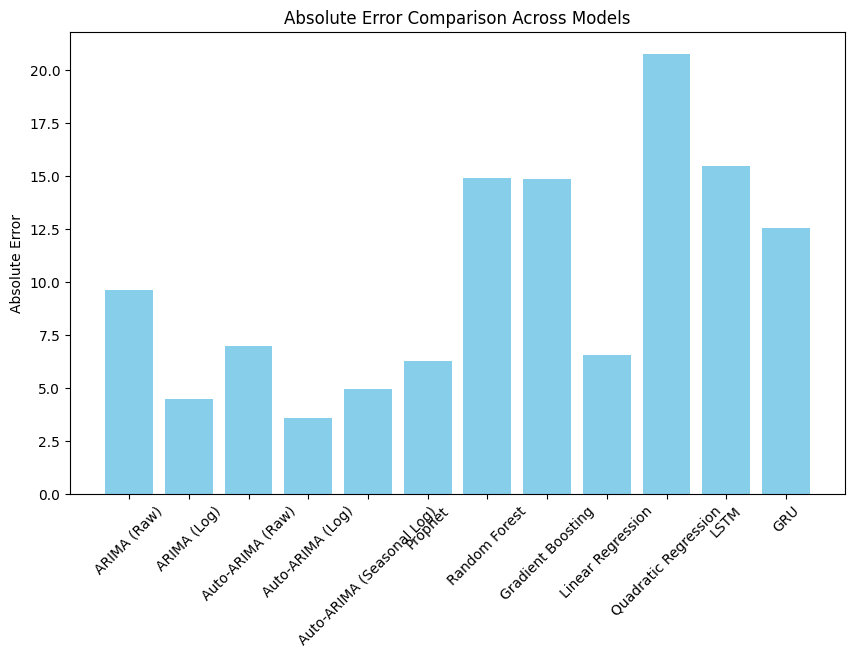

In [18]:
print("\n### Updated Results with LSTM and GRU ###")
results

# Visualize comparison
plt.figure(figsize=(10, 6))
plt.bar(results['Model'], results['Absolute Error'], color='skyblue')
plt.title('Absolute Error Comparison Across Models')
plt.ylabel('Absolute Error')
plt.xticks(rotation=45)
plt.show()

Implemented LSTM and GRU. LSTM doesn't perform well. GRU performs better. But not by a large margin. Rolling to Linear Regression / ARIMA